In [ ]:
import sys
import jax.numpy as np
import numpy as onp
import os
import pandas as pd
import matplotlib.pyplot as plt

from jax import jit, random
from inrmri.new_radon import ForwardRadonOperator, get_weight_freqs
from inrmri.basic_nn import weighted_loss 
from inrmri.utils import meshgrid_from_subdiv_autolims, save_matrix_and_dict_in_zpy   
from inrmri.utils import denoise_loss_batch
import optax 
from inrmri.advanced_training import OptimizerWithExtraState, train_with_updates_ms_framewise, train_with_updates_ms_nspokeswise, train_with_updates_ms_spokewise
import itertools
from inrmri.utils_rdls import get_predim, get_predim_ms, get_shedule, get_predim_direct_ms
from inrmri.utils_rdls import create_folder, save_frames_as_gif_with_pillow
from inrmri.utils_rdls import get_varying_keys, config_to_foldername
from inrmri.utils_rdls import plot_curves, plot_curves_and_mins, best_images_visualization, plot_multi_axis, multiple_images_visualization
from inrmri.dip import MS_TD_DIP_Net, multi_slice_circle_generator  # new
from inrmri.dip import index_based_probs, safe_sample_index, sample_unique_per_target
from inrmri.utils_rdls import plot_curves_and_mins_2
from inrmri.utils_rdls import safe_normalize, get_center

# --- Clear memory after each run ---
import gc
import jax
from jax._src import dispatch

In [58]:
from inrmri.image_processor import BeforeLinRegNormalizer
from inrmri.basic_plotting import full_halph_FOV_space_time 
from inrmri.utils_rdls import safe_normalize, get_center

In [59]:
def make_folder(exp_save_folder):
    if not os.path.exists(exp_save_folder):
        os.makedirs(exp_save_folder)

def plot_and_save(exp_save_folder, processed_matrices, crop_ns_list, selected_slice, saturation, frame, titles):
    fig, axs = full_halph_FOV_space_time(processed_matrices, crop_ns=crop_ns_list[selected_slice-1], saturation=saturation, frame=frame)
    for ax, title in zip(axs, titles):
        ax[0].set_title(title)
    fig.savefig( exp_save_folder + 'plot_s' +  str(selected_slice) + '_f' + str(frame) + '.png', dpi=600)

In [60]:
# --- volunteer ---
volunteer = 'CM'
dataaset = 'DATA_1.5T'
model = 'tdDIP'

# --- DATA ---
base_path             =     '/mnt/workspace/datasets/pulseqCINE/'
base_folder           =     base_path + dataaset + '/' + volunteer + '/'
train_data_folder     =     base_folder + 'traindata/'
model_path            =     base_folder + model + '/'

# experiment to be analyzed
experiment_variables = ['total_kiter','batch_size']
experiment_name = '_'.join(experiment_variables)
df_total   = pd.read_csv(model_path + experiment_name + ".csv", delimiter=';')
df_summary = pd.read_csv(model_path + experiment_name + "_summary.csv", delimiter=';')

In [61]:
# Information
# variables
print('VARIABLES')
for experiment_variable in experiment_variables:
    print(experiment_variable + ': ' + str(df_total[experiment_variable].unique()))
print()
# experiments
print('EXPERIMENTS')
print('slices' + ': ' + str(df_total['slice'].unique()))

VARIABLES
total_kiter: [ 500 1000]
batch_size: [1 2]

EXPERIMENTS
slices: [1 2]


In [62]:
experiment_name_folder = model_path + experiment_name + '/'
make_folder(experiment_name_folder)

## Comparative figure

In [63]:
slice         =   1
frame         =   0
total_slices  =   8
num_frames    =   30

h_params = {
    'total_kiter':    1000,
    'batch_size':     2,   
}

crop_ns = [30,30,30,30]
saturation = 0.5
frame  = 0

In [64]:
dataset_name          = 'slice_' + str(slice) + '_' + str(total_slices) +'_nbins' + str(num_frames)
path_dataset          = train_data_folder + dataset_name + '.npz'
save_folder           = model_path + dataset_name.replace(".", "_") + '/'
# load data
data             =  onp.load(path_dataset)
recon_grasp      =  data['recon_grasp']
recon_sense      =  data['recon_sense']
recon_fs         =  data['recon_fs']

recon_grasp.shape, recon_sense.shape, recon_fs.shape

((256, 256, 30), (256, 256, 30), (256, 256, 30))

In [65]:
folder_name_list = []
for variable in h_params.keys():
    folder_name_list.append( variable + '=' +str(h_params[variable]) )
folder_name      = '__'.join(folder_name_list)
folder_path      = model_path + 'slice_'+str(slice) +'_'+str(total_slices)+'_nbins30' + '/'+experiment_name + '/' + folder_name + '/'
path_best_recon  = folder_path + 'best_recon.npz'
best_recon             =  onp.load(path_best_recon)['best_recon']

In [66]:
recon_grasp    = get_center(recon_grasp) 
recon_grasp    = safe_normalize(recon_grasp) 

recon_sense    = get_center(recon_sense) 
recon_sense    = safe_normalize(recon_sense) 

recon_fs       = get_center(recon_fs) 
recon_fs       = safe_normalize(recon_fs) 

best_recon       = safe_normalize(best_recon) 

In [68]:
matrices_list = [recon_fs, best_recon, recon_grasp, recon_sense]
titles        = ['Groud Truth', 'ST-DIP', 'GRASP', 'SENSE']

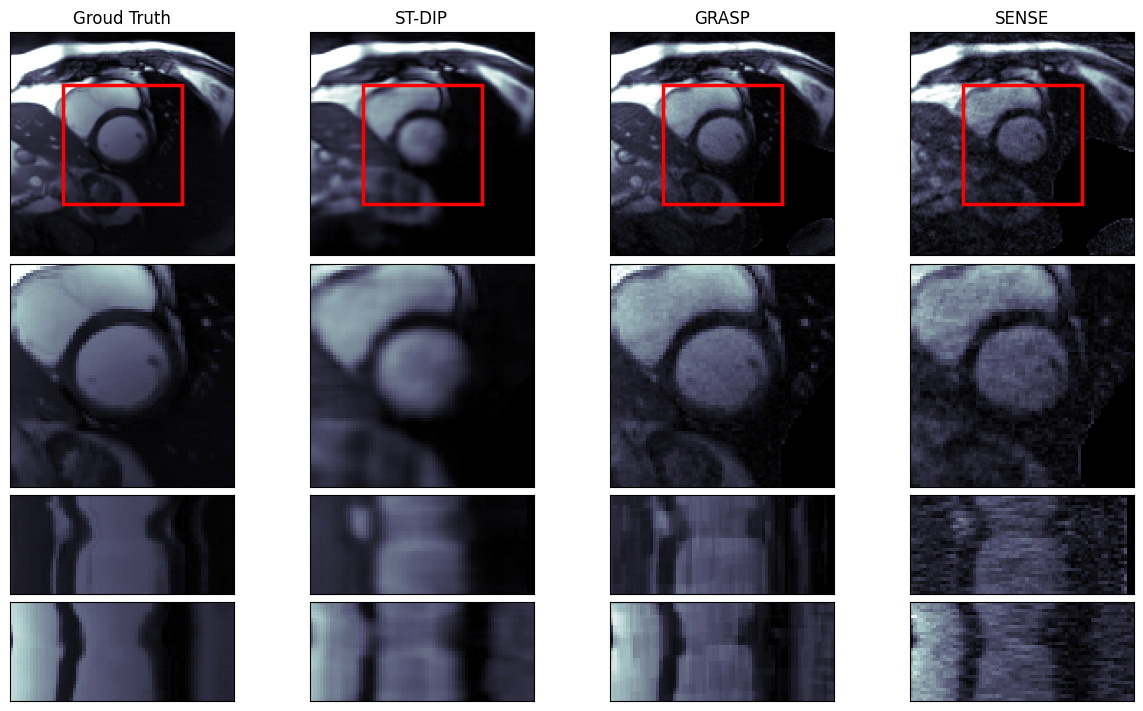

In [70]:
fig, axs = full_halph_FOV_space_time(matrices_list, crop_ns=crop_ns, saturation=saturation, frame=frame)
for ax, title in zip(axs, titles):
    ax[0].set_title(title)

In [28]:
plot_and_save(experiment_name_folder, processed_matrices, crop_ns_list, selected_slice, saturation, frame, titles)

NameError: name 'processed_matrices' is not defined

In [25]:
df_total.head()

,total_kiter,batch_size,duration [s],duration [min],duration,it,loss,var,ssim,psnr,ap,experiment_folder,slice,log_it,log_var,log_loss,log_ssim,log_psnr,log_ap
0,500,1,77.008928,1.283482,0h 1m 17.01s,348,0.071588,0.001424,0.936529,24.470469,0.086858,/mnt/workspace/datasets/pulseqCINE/DATA_1.5T/C...,1,"[48, 98, 148, 198, 248, 298, 348]","[0.008123771287500858, 0.003132305108010769, 0...","[0.05200113356113434, 0.060804158449172974, 0....","[0.6275720000267029, 0.8684579133987427, 0.866...","[18.47454261779785, 21.25480079650879, 22.1876...","[0.345464289188385, 0.1821281760931015, 0.1469..."
1,500,2,93.801850,1.563364,0h 1m 33.80s,348,0.099621,0.000841,0.959679,26.372324,0.056056,/mnt/workspace/datasets/pulseqCINE/DATA_1.5T/C...,1,"[48, 98, 148, 198, 248, 298, 348]","[0.007939696311950684, 0.002203923650085926, 0...","[0.14452959597110748, 0.14149488508701324, 0.1...","[0.800852358341217, 0.9060855507850647, 0.9429...","[20.23287010192871, 22.969423294067383, 25.090...","[0.23044657707214355, 0.12271977961063385, 0.0..."
2,1000,1,126.814373,2.113573,0h 2m 6.81s,748,0.058923,0.000701,0.954339,26.836988,0.050368,/mnt/workspace/datasets/pulseqCINE/DATA_1.5T/C...,1,"[48, 98, 148, 198, 248, 298, 348, 398, 448, 49...","[0.013172712177038193, 0.007523609325289726, 0...","[0.05130232870578766, 0.06150300055742264, 0.0...","[0.5427754521369934, 0.8489256501197815, 0.901...","[14.742035865783691, 20.638601303100586, 23.08...","[0.8159322738647461, 0.2098926156759262, 0.119..."
3,1000,2,158.438190,2.640636,0h 2m 38.44s,698,0.098322,0.000426,0.966414,27.925007,0.039206,/mnt/workspace/datasets/pulseqCINE/DATA_1.5T/C...,1,"[48, 98, 148, 198, 248, 298, 348, 398, 448, 49...","[0.008242528885602951, 0.0025744468439370394, ...","[0.14901581406593323, 0.1335359513759613, 0.12...","[0.7862911820411682, 0.91602623462677, 0.92090...","[19.619829177856445, 23.847719192504883, 23.78...","[0.2653837203979492, 0.10025012493133545, 0.10..."
4,500,1,72.232488,1.203875,0h 1m 12.23s,298,0.061195,0.001153,0.900308,23.249565,0.113767,/mnt/workspace/datasets/pulseqCINE/DATA_1.5T/C...,2,"[48, 98, 148, 198, 248, 298, 348]","[0.009600924327969551, 0.0037583119701594114, ...","[0.06955888867378235, 0.0512460358440876, 0.09...","[0.7583289742469788, 0.7806094288825989, 0.843...","[18.41630744934082, 19.99748420715332, 21.8173...","[0.346213161945343, 0.2405613213777542, 0.1582..."


In [26]:
df_summary.head()

,total_kiter,batch_size,var_mean,var_std,ssim_mean,ssim_std,psnr_mean,psnr_std,ap_mean,ap_std,...,log_ssim_mean,log_ssim_std,log_psnr_mean,log_psnr_std,log_ap_mean,log_ap_std,log_loss_mean,log_loss_std,it,log_it
0,500,1,0.001289,0.000191,0.918419,0.025612,23.860017,0.863309,0.100313,0.019028,...,"[0.6929504871368408, 0.8245337009429932, 0.855...","[0.06537848711013794, 0.0439242422580719, 0.01...","[18.445425033569336, 20.626142501831055, 22.00...","[0.029117584228515625, 0.6286582946777344, 0.1...","[0.345838725566864, 0.21134474873542786, 0.152...","[0.0003744363784790039, 0.029216572642326355, ...","[0.060780011117458344, 0.05602509528398514, 0....","[0.008778877556324005, 0.0047790613025426865, ...",348,"[48, 98, 148, 198, 248, 298, 348]"
1,500,2,0.000751,0.000128,0.953868,0.008218,26.443404,0.100522,0.054850,0.001705,...,"[0.8169406652450562, 0.9119040966033936, 0.917...","[0.0160883367061615, 0.005818575620651245, 0.0...","[20.775264739990234, 23.42502784729004, 24.374...","[0.5423946380615234, 0.45560455322265625, 0.71...","[0.20397529006004333, 0.11055028438568115, 0.0...","[0.026471279561519623, 0.012169498950242996, 0...","[0.15969456732273102, 0.1418929398059845, 0.13...","[0.015164971351623535, 0.00039806216955184937,...",348,"[48, 98, 148, 198, 248, 298, 348]"
2,1000,1,0.000660,0.000058,0.958420,0.005771,27.011864,0.247312,0.048160,0.003123,...,"[0.589643120765686, 0.8047378659248352, 0.8874...","[0.04686763882637024, 0.04418778419494629, 0.0...","[16.21382713317871, 19.579275131225586, 22.487...","[1.4717907905578613, 1.059326171875, 0.5972414...","[0.6127910017967224, 0.27397072315216064, 0.13...","[0.20314127206802368, 0.06407811492681503, 0.0...","[0.06317078322172165, 0.05772576108574867, 0.0...","[0.01186845451593399, 0.0037772394716739655, 0...",748,"[48, 98, 148, 198, 248, 298, 348, 398, 448, 49..."
3,1000,2,0.000408,0.000026,0.967567,0.001630,27.924771,0.000334,0.038989,0.000307,...,"[0.7738876342773438, 0.9106303453445435, 0.919...","[0.01240357756614685, 0.0053958892822265625, 0...","[19.791778564453125, 23.422916412353516, 24.19...","[0.1719493865966797, 0.4248018264770508, 0.411...","[0.2539110481739044, 0.11039936542510986, 0.09...","[0.0114726722240448, 0.010149236768484116, 0.0...","[0.16469326615333557, 0.1396089792251587, 0.12...","[0.015677452087402344, 0.006073027849197388, 0...",698,"[48, 98, 148, 198, 248, 298, 348, 398, 448, 49..."
